In [624]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from skimage import transform as tf
from skimage.measure import label, regionprops
from skimage.transform import resize
from matplotlib import pyplot as plt
from sklearn.utils import check_random_state
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier

In [625]:
#150 is suitable for at most 6 char
def generator(text, shear=0, size=(150, 24),scale=1):
    bg = Image.new("L", size, "black")   
    draw = ImageDraw.Draw(bg)
    font = ImageFont.truetype(r"Coval-Black.ttf", 22)
    draw.text((1,1),text, fill=1, font=font)
    image = np.array(bg)
    # shear the image as give value
    affine_tf = tf.AffineTransform(shear=shear)
    image = tf.warp(image, affine_tf)
    image = image / image.max()
    return image

In [626]:
def segment_image(image):
    # We need to split the chars in the image. To avoid misclassification, I set a tighter boundage.
    limage = label(image > 0.8)
    subimages = []
    for region in regionprops(limage):
        x1, y1, x2, y2 = region.bbox
        subimages.append(image[x1:x2,y1:y2])
    return subimages

In [627]:
tword = "EA888G2"
image=generator(tword, shear=0.3)
subimages = segment_image(image)

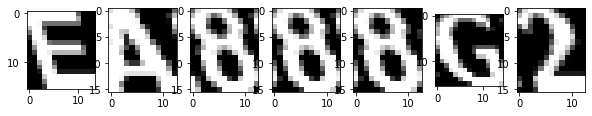

In [628]:
f, axes = plt.subplots(1, len(subimages), figsize=(10, 3))
for i in range(len(subimages)):
    axes[i].imshow(subimages[i], cmap="gray")

In [629]:
random_state = check_random_state(8)

#list of 10 numbers and 26 letters
letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890")
#List of possible shear values
shear_values = np.arange(0, 0.5, 0.05)
shear_values

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45])

In [630]:
def generate_sample(random_state=None):
    random_state = check_random_state(random_state)
    letter = random_state.choice(letters)
    shear = random_state.choice(shear_values)
    # generate training set with different letters
    return generator(letter, shear=shear, size=(25, 25)),letters.index(letter)

In [631]:
dataset, targets = zip(*(generate_sample(random_state) for i in range(2000)))
dataset = np.array([tf.resize(segment_image(sample)[0], (20, 20)) for sample in dataset])
dataset = np.array(dataset, dtype='float') 
targets = np.array(targets)

In [632]:
onehotencoder = OneHotEncoder()
y = onehotencoder.fit_transform(targets.reshape(targets.shape[0],1)) 
y = y.todense()
print(dataset.shape[0], dataset.shape[1] ,dataset.shape[2])

2000 20 20


In [633]:
X = dataset.reshape((dataset.shape[0], dataset.shape[1] * dataset.shape[2]))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

In [634]:
clf = MLPClassifier(hidden_layer_sizes=(100,), random_state=14, max_iter=1000)

In [635]:
clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=14, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [636]:
y_pred = clf.predict(X_test)
f1_score(y_pred=y_pred, y_true=y_test, average='macro')

1.0

In [637]:
from sklearn.metrics import classification_report

#correctness for 10 numbers and 26 letters (100% correct for individual prediction)
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         9
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         8
           9       1.00      1.00      1.00         4
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         6
          12       1.00      1.00      1.00         9
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00         5
          17       1.00    

In [638]:
def predict_image(raw_image, neural_network):
    subimages = segment_image(raw_image)
    #convert 2D graph to 1D array
    dataset = np.array([tf.resize(subimage, (20, 20)) for subimage in subimages])
    X_test = []
    X_test_raw = dataset.reshape((dataset.shape[0], dataset.shape[1] * dataset.shape[2]))
    #Sometimes we may have an empty subimage (normally the last one). We need to get rid of them.
    for testelement in X_test_raw:
        if (sum(testelement) < 360):
            X_test.append(testelement)
    y_pred = neural_network.predict_proba(X_test)
    predictions = np.argmax(y_pred, axis=1)
    predicted_word = str.join("", [letters[prediction] for prediction in predictions])
    return predicted_word

In [639]:
def test_prediction(word, neural_network, shear=0.2):
    raw_image = generator(word, shear=shear)
    prediction = predict_image(raw_image, neural_network)
    return word == prediction, word, prediction

In [640]:
#use nltk to be the word bank of the testing cases
import nltk
nltk.download('words')

from nltk.corpus import words
valid_words = [word.upper() for word in words.words() if len(word) <7]

[nltk_data] Downloading package words to /Users/abc/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [641]:
num_correct=[0,0,0,0,0,0,0,0,0,0]
num_incorrect=[0,0,0,0,0,0,0,0,0,0]
shear_values = np.arange(0.1, 0.5, 0.05)
for word in valid_words:
    if (word!=''):
        shear = random_state.choice(shear_values)
        correct, word, prediction = test_prediction(word, clf,shear=shear)
        index=int(shear/0.05)
        if correct:
            num_correct[index] += 1
        else:
            num_incorrect[index] += 1

for i in range(2,len(num_correct)):
    print("correct prediction:",num_correct[i],"incorrect prediction:",num_incorrect[i])

correct prediction: 4470 incorrect prediction: 8
correct prediction: 4431 incorrect prediction: 8
correct prediction: 4448 incorrect prediction: 4
correct prediction: 4410 incorrect prediction: 0
correct prediction: 4525 incorrect prediction: 1
correct prediction: 4286 incorrect prediction: 145
correct prediction: 3466 incorrect prediction: 918
correct prediction: 1324 incorrect prediction: 3064


In [642]:
for i in [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45]:
    index=int(i/0.05)
    print("correctness for",i,"is ",(num_correct[index])/(num_correct[index]+num_incorrect[index])*100,"%")

correctness for 0.1 is  99.8213488164359 %
correctness for 0.15 is  99.8213488164359 %
correctness for 0.2 is  99.91015274034142 %
correctness for 0.25 is  100.0 %
correctness for 0.3 is  100.0 %
correctness for 0.35 is  99.97790543526293 %
correctness for 0.4 is  79.0602189781022 %
correctness for 0.45 is  30.17319963536919 %


So from this result, we can find error goes up when we increase shear.

In [643]:
tword = "EA888G2"
image=generator(tword, shear=0.7)
subimages = segment_image(image)

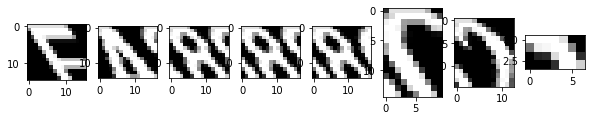

In [644]:
f, axes = plt.subplots(1, len(subimages), figsize=(10, 3))
for i in range(len(subimages)):
    axes[i].imshow(subimages[i], cmap="gray")

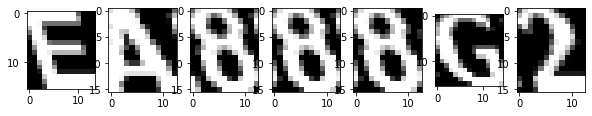

In [645]:
tword = "EA888G2"
image=generator(tword, shear=0.3)
subimages = segment_image(image)
f, axes = plt.subplots(1, len(subimages), figsize=(10, 3))
for i in range(len(subimages)):
    axes[i].imshow(subimages[i], cmap="gray")

This is because when shear value becomes very large, it's hard to split the letters using vertical lines.